# Hospitalization Prediction for Elderly People


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, classification_report, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer

from src.eda import *
from src.config import *
from src.data_extract import *
from src import feature_selection as fs
from src.evaluation import *


# 1. Data Extraction


* *The Mexican Health and Aging Study* (**MHAS**) is a dataset of household surveys designed to collect information on the health, economic status, and quality of life of older adults.
The survey was conducted over 5 time periods, technically known as **Waves**. 
In addition, there are three study subjects: the respondent (r), the spouse (s), and the household (H). For this study, only the first two were used.



## 1.1. Load data

* The data is available on the official **MHAS** site. They are extracted and processed by a **Dataframe**.

In [2]:
# Run only once, or if you need to rebuild the original data
setup_data()

Current directory: c:\Users\baldo\ANYONEAI\Pfinal2\HPEP-Project
Created 'data' folder.
Created 'original' folder within 'data'.
ZIP downloaded successfully.
ZIP extracted successfully.


## 1.2. Extract data.

* To prepare the data for exploratory analysis (**EDA**) and modeling, common characteristics for the two study subjects are considered and merged into a single data set. 

In [3]:
mhas = get_data_frame()
df = extract(mhas)

c:\Users\baldo\ANYONEAI\Pfinal2\HPEP-Project\src\data_extract.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s1[p1] = df[s1].copy()
c:\Users\baldo\ANYONEAI\Pfinal2\HPEP-Project\src\data_extract.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s1[p1] = df[s1].copy()
c:\Users\baldo\ANYONEAI\Pfinal2\HPEP-Project\src\data_extract.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

# 2. EDA.
* **Data structure**: The data set is divided into 15 sections. Each section quantifies different aspects related to health and socio-economic aspects..

## 2.1. Identification of the target variable
* The target variable belongs to *Section C: Health Care Utilization and Insurance* and is labeled **Medical Care Utilization: Hospital** *`(r/s)#hosp1y`*, where *"r"* refers to "respondent" and *"s"* to "spouse".  Finally, *"#"* goes from 1 to 5 and refers to waves. 

* *rwhosp1y* indicates whether the respondent reports at least one overnight hospital stay in the last 12 months. RwHOSP1Y is coded as 0 if the respondent had no overnight hospital stays, and is coded as 1 if the respondent had at least one overnight hospital stay. 

* *swhosp1y* is taken from the spouse value in wave "w" for *rwhosp1y*. In addition to the special default codes used in *rwhosp1y*, if the respondent is not considered matched in the current cycle and is assumed to be single, a special default value of .u is used. In addition, if the respondent is not considered matched in the current cycle but reports being married, a special default value of .u is used. Similarly, if the respondent is not considered matched in the current cycle but reports being married, a special omitted value of .v is used.

In [4]:
# renaming the dataframe for convenience
target = "pahosp1y"


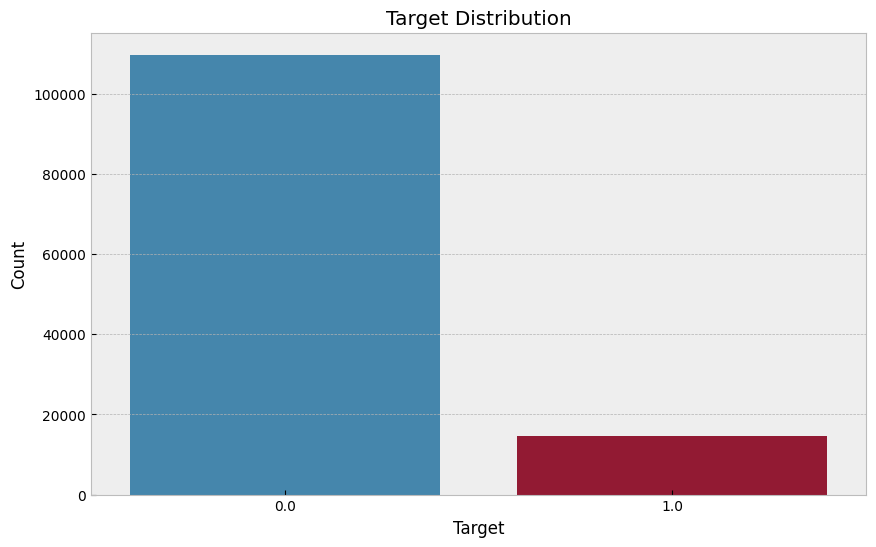

In [5]:

# plottiing the unique values of the target to spot imbalance}
with plt.style.context('bmh'):
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x=target, data=df, linewidth=0)
        ax.set_xlabel("Target")
        ax.set_ylabel("Count")
        ax.set_title("Target Distribution")
        plt.show()

## 2.2. Missing values.

Number of features: 442


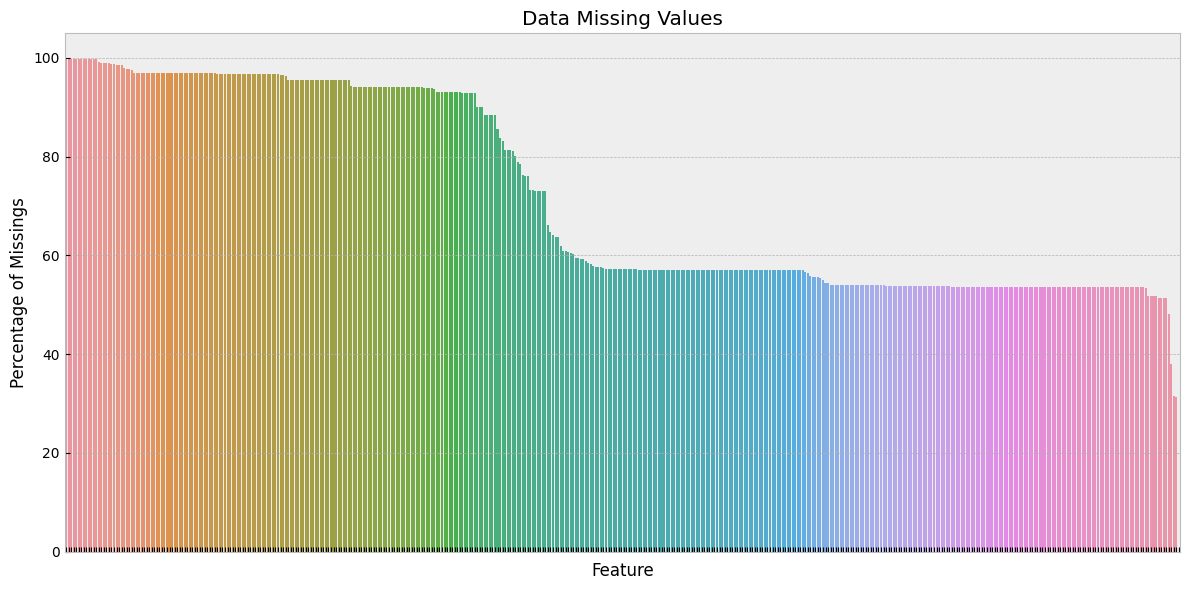

In [6]:
print(f"Number of features: {df.shape[1]}")
plot_missing_values(df)

## 2.3. Data type and unique values.
* Data consists primarily of binary, discrete, and, to a lesser extent, continuous data.

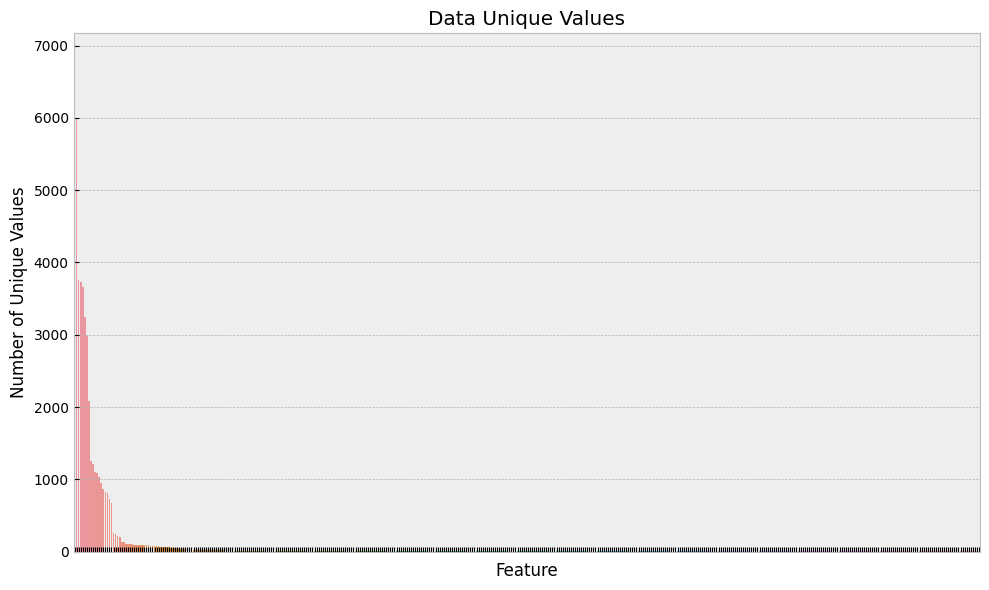

In [7]:
plot_uniques(df)

## 2.4. Correlation between binary features and the target.

* A clear relationship between the characteristics and the target variables is observed by Cramer's V. This statistic is a measure of effect size for the chi-squared test of independence. It measures how two categorical fields are related.

Effect Size (ES) / Interpretation

ES ≤ 0.2 The result is weak. Although the result is statistically significant, the fields are only weakly associated.

0.2 < ES ≤ 0.6 The result is moderate. The fields are moderately related.

**ES > 0.6 The result is strong. The fields are strongly associated.**

c:\Users\baldo\ANYONEAI\Pfinal1\Final_Projects\src\eda.py:208: RuntimeWarning: invalid value encountered in scalar divide
  V = np.sqrt(phi_c / min(contingency_table.shape[0] - 1, contingency_table.shape[1] - 1))


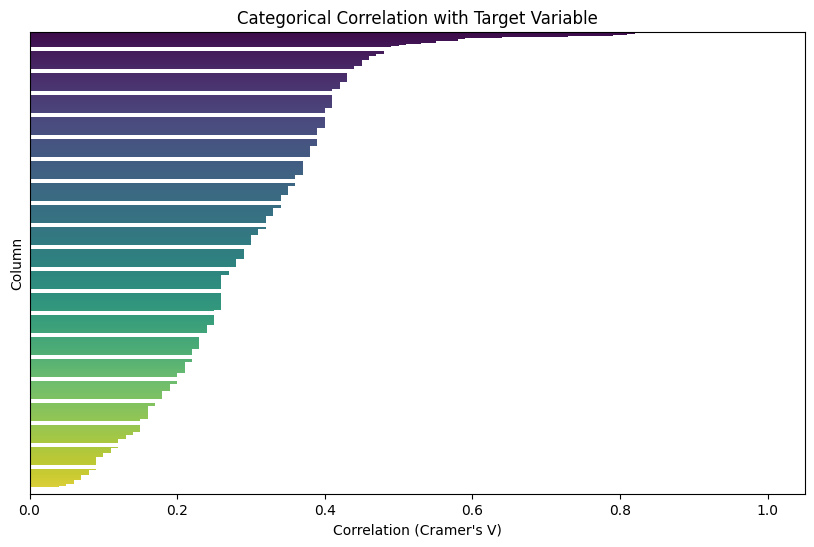

In [8]:
plot_categorical_correlation(df, target)

# 3. Model


## 3.1. Feature Selection and Preprocessing

In [6]:
# filtering the data by elderly people only.
df = df.loc[df['paagey']>=50]

# The selected features, we believe are relevant to the model.
selected=['pahosp1y','pahip50e', 'padadage', 'pamomage', 
          'pahibpe', 'parespe', 'pacholst', 'pagrossaa', 
          'paosleep', 'pafallinj', 'pacancre', 'paswell', 
          'parafaany', 'pawheeze', 'paagey', 
          'paarthre', 'padiabe', 'parjudg', 'paweight', 
          'paclims', 'pastroke', 'pasmokev', 
          'pahearaid', 'pameds', 'paheight', 'paglasses', 
          'paeat', 'papaina', 'pagender', 'padrinkb']

print(f"There are {len(selected)} features selected")

df3 = df.where(df['cpindex'] <=  109).dropna(subset=['cpindex'])

df_s = df3.dropna(subset=[target]) 
df_s = df_s[selected].copy()

nulls_percentage = df_s.isnull().sum(axis=1) / len(df.columns)
df_s = df_s[(df_s[target] != 0) | (nulls_percentage <= 0.5)]

# splitting the data into X and y
y_df = df_s[target]
X_df = df_s.drop(target,axis=1)

There are 30 features selected


In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset in train and test data
df_train, df_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, shuffle=True)

# Imputing nan
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent') # Imputer using the mode
X_train = imputer.fit_transform(df_train) 

# Scaling the train data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Normalizing the train data
transformer = PowerTransformer(method='yeo-johnson')
X_train = transformer.fit_transform(X_train)

## Now we apply the same fot test dataset
X_test = imputer.transform(df_test)

# Scaling the test data
X_test = scaler.transform(X_test)

# Normalizing the test data
X_test = transformer.transform(X_test)

## 3.2. Logistic Regression Model

In [8]:
from sklearn.linear_model import LogisticRegression
import time

log_reg = None
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(X_train, y_train)

# Train data predictions (class 1)
log_reg_train = log_reg.predict_proba(X_train)[:, 1]

# Validation data predictions (class 1)
log_reg_val = log_reg.predict_proba(X_test)[:, 1]

# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_test, y_score=log_reg_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.7365
Validation ROC AUC Score: 0.7395


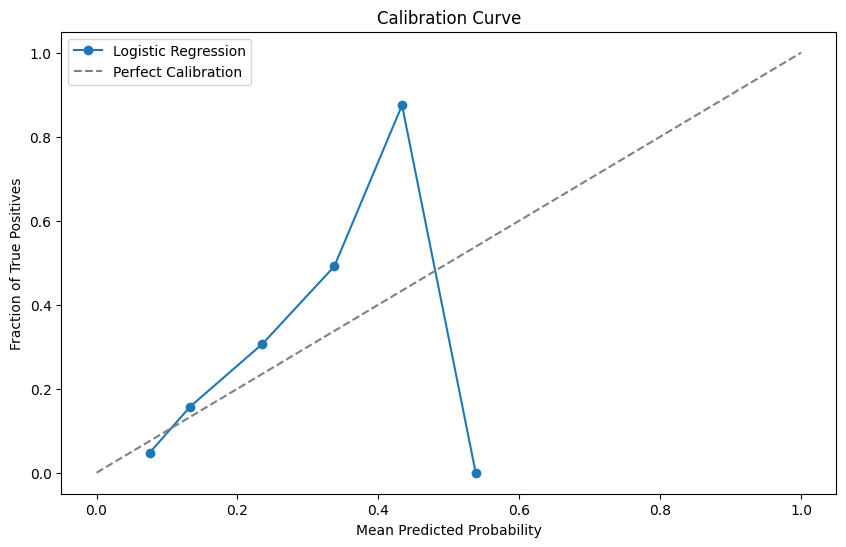

In [9]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


# Get true positive fraction and predicted mean probability from the model
fraction_of_positives1, mean_predicted_value1 = calibration_curve(y_test, log_reg_val, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value1, fraction_of_positives1, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of True Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

## 3.3. Random Forest Model

In [10]:
from sklearn.ensemble import RandomForestClassifier
import time

# Initialize RandomForest classifier with n_jobs=-1 to use all CPU cores
rf = RandomForestClassifier(n_jobs=-1)

# Measure start time
start_time = time.time()

# Train the model
rf.fit(X_train, y_train)

# Measure completion time
end_time = time.time()

# Calculate elapsed time
training_time = end_time - start_time

# Print training time
print(f"Training time: {training_time} seconds")

# The trained model is in the variable 'rf'

# Train data predictions (class 1)
rf_pred_train = rf.predict_proba(X_train)[:, 1]

# Validation data predictions (class 1)
rf_pred_test = rf.predict_proba(X_test)[:, 1]


# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_test = roc_auc_score(y_true=y_test, y_score=rf_pred_test)
print(f"Validation ROC AUC Score: {roc_auc_test:.4f}")

Training time: 2.2550933361053467 seconds
Train ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.9417


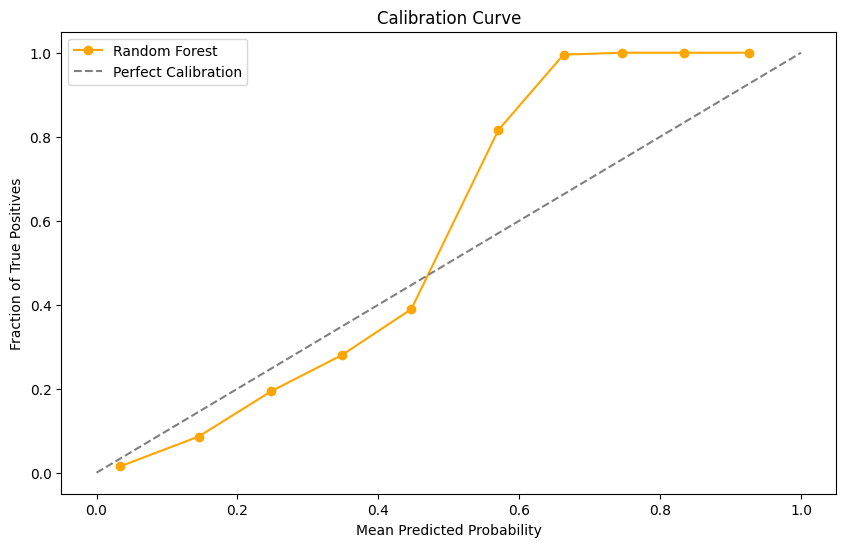

In [43]:
# Get true positive fraction and predicted mean probability from the model
fraction_of_positives2, mean_predicted_value2 = calibration_curve(y_test, rf_pred_test, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value2, fraction_of_positives2, marker='o', label='Random Forest', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of True Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()




## 3.4. XGB Classifier Model

In [12]:
# creating variables that captures the proportion of classes in the target.
zeros=y_train.value_counts()[0]
ones=y_train.value_counts()[1]

# This are the parameters that we found to be the best for the model.
params={
        'max_depth': 8, 
        'subsample': 0.759545947005226,
        'colsample_bytree': 0.9075616505206274, 
        'eta': 0.07568753700048324, 
        'min_child_weight': 5, 
        'n_estimators': 561, 
        'scale_pos_weight': (zeros/ones)-2.5,
        'n_jobs':-1,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
}

# instantiating the model
model = XGBClassifier(**params)

In [13]:
kf = KFold(n_splits=7)

y_test_all = []
y_pred_all = []
y_pred_prob_all = []


for train_index, test_index in kf.split(X_train):
    _X_train, _X_test = X_train[train_index], X_train[test_index]
    _y_train, _y_test = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(_X_train, _y_train, 
            eval_set=[(_X_train, _y_train), (_X_test, _y_test)], 
            early_stopping_rounds=3) 
    
    y_test_all.extend(_y_test)
    y_pred_all.extend(model.predict(_X_test))
    y_pred_prob_all.extend(model.predict_proba(_X_test))

[0]	validation_0-logloss:0.67039	validation_1-logloss:0.67139


C:\Users\baldo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.64939	validation_1-logloss:0.65146
[2]	validation_0-logloss:0.63117	validation_1-logloss:0.63422
[3]	validation_0-logloss:0.61436	validation_1-logloss:0.61835
[4]	validation_0-logloss:0.60068	validation_1-logloss:0.60519
[5]	validation_0-logloss:0.58784	validation_1-logloss:0.59289
[6]	validation_0-logloss:0.57608	validation_1-logloss:0.58173
[7]	validation_0-logloss:0.56500	validation_1-logloss:0.57129
[8]	validation_0-logloss:0.55431	validation_1-logloss:0.56134
[9]	validation_0-logloss:0.54506	validation_1-logloss:0.55309
[10]	validation_0-logloss:0.53643	validation_1-logloss:0.54517
[11]	validation_0-logloss:0.52867	validation_1-logloss:0.53823
[12]	validation_0-logloss:0.52101	validation_1-logloss:0.53137
[13]	validation_0-logloss:0.51398	validation_1-logloss:0.52518
[14]	validation_0-logloss:0.50775	validation_1-logloss:0.51950
[15]	validation_0-logloss:0.50218	validation_1-logloss:0.51449
[16]	validation_0-logloss:0.49630	validation_1-logloss:0.50942
[

In [14]:
# Convertir las listas en arrays numpy
y_test_all = np.array(y_test_all)
y_pred_all = np.array(y_pred_all)
y_pred_prob_all = np.array(y_pred_prob_all)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_test_all, y_pred_prob_all)

# Calcular el classification_report
report = classification_report(y_test_all, y_pred_all)

print(f'AUC: {auc}')
print(f'F1: {f1_score(y_test_all, y_pred_all)}')
print(report)

AUC: 0.8551848172445238
F1: 0.6173875054608999
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96     49026
         1.0       0.63      0.60      0.62      5869

    accuracy                           0.92     54895
   macro avg       0.79      0.78      0.79     54895
weighted avg       0.92      0.92      0.92     54895



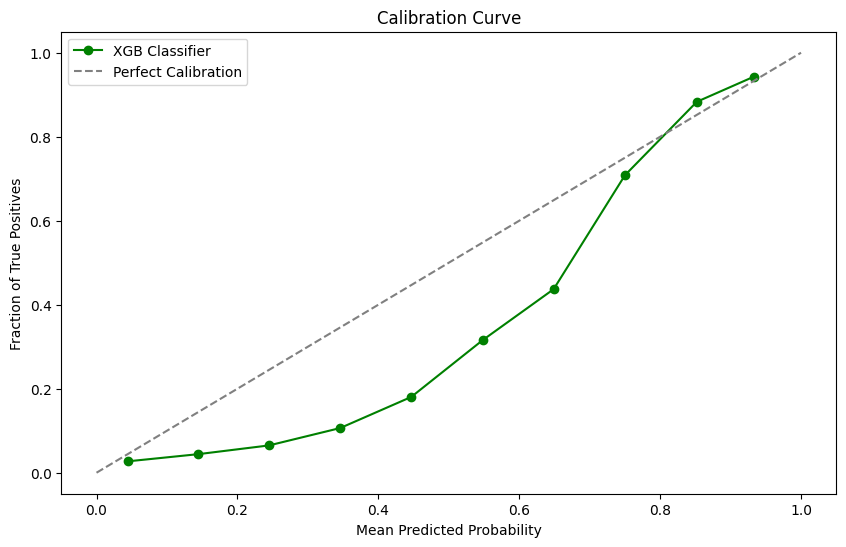

In [16]:
# Get true positive fraction and predicted mean probability from the model
fraction_of_positives3, mean_predicted_value3 = calibration_curve(y_test_all, y_pred_prob_all, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value3, fraction_of_positives3, marker='o', label='XGB Classifier', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of True Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

# 4. Evaluation

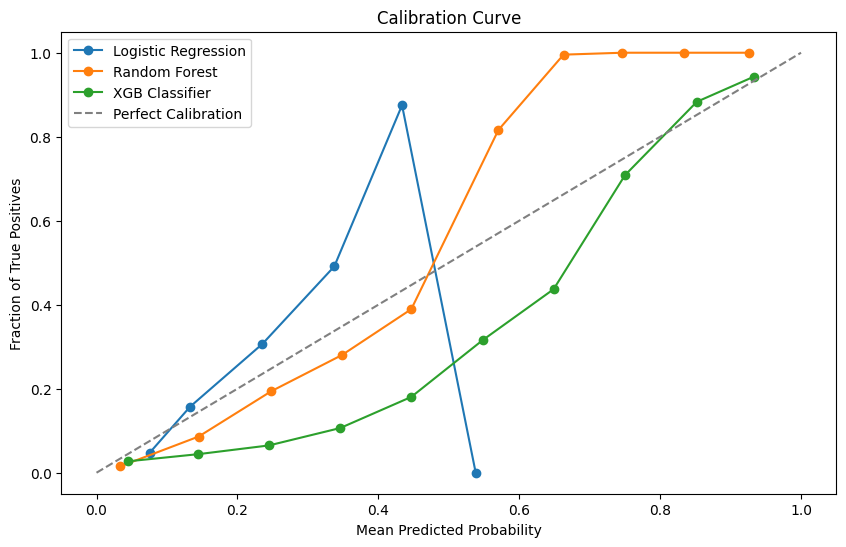

In [17]:
# Plot the calibration curve
plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value1, fraction_of_positives1, marker='o', label='Logistic Regression')
plt.plot(mean_predicted_value2, fraction_of_positives2, marker='o', label='Random Forest')
plt.plot(mean_predicted_value3, fraction_of_positives3, marker='o', label='XGB Classifier')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of True Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

# 5. Exporting the model

## 5.1 Saving the model

In [10]:
model = rf
model

RandomForestClassifier(n_jobs=-1)

In [11]:
# scaler, transformer
transformers = {"imputer":imputer, "scaler":scaler, "transformer":transformer}
transformers

{'imputer': SimpleImputer(strategy='most_frequent'),
 'scaler': StandardScaler(),
 'transformer': PowerTransformer()}

In [12]:
import pickle

model_type = "RFC_model" # This is the name for the filename of the model

output_file = f"hospitalization-{model_type}.bin"

with open(output_file, "wb") as f_out:
    pickle.dump((transformers, model), f_out)


## 5.2 Load the model (Testing)

In [13]:
import pickle

model_type = "RFC_model" # This is the name for the filename of the model

input_file = f"hospitalization-{model_type}.bin" # Use the same name than above

with open(input_file, "rb") as f_in:
    transformers_imported, model_imported = pickle.load(f_in)

transformers_imported, model_imported

({'imputer': SimpleImputer(strategy='most_frequent'),
  'scaler': StandardScaler(),
  'transformer': PowerTransformer()},
 RandomForestClassifier(n_jobs=-1))

In [14]:
# Import transformer objects from pickle
imputer_imported = transformers_imported["imputer"]
scaler_imported = transformers_imported["scaler"]
transformer_imported = transformers_imported["transformer"]

In [31]:
def extract_patient(pos, df):    
    """
    Extracts the target variable and patient information from the dataframe.

    Parameters:
    pos (int): The position of the patient in the dataframe.
    df (pandas.DataFrame): The dataframe containing patient information.

    Returns:
    tuple: A tuple containing the target variable (y_patient) and a dictionary (patient_dict) 
        representing the patient information.
    """
    target = "pahosp1y"
    y_patient = df[target].iloc[pos]
    # print(y_patient) # Print it the patient was hospitalizated 

    # Convert patient to dict similar to format of the json in the api
    patient_dict = df.drop(target, axis=1).iloc[pos].to_dict()
    # print(patient_dict)
    return y_patient, patient_dict

In [30]:
def predict_patient(patient_dict, transformers, model):
    """
    Predicts the hospitalization probability for a given patient.

    Parameters:
    - patient_dict (dict): A dictionary containing the patient's information.
    - transformers (dict): A dictionary containing the transformers used for data preprocessing.
    - model: The trained machine learning model.

    Returns:
    - hospitalization (bool): True if the patient is predicted to be hospitalized, False otherwise.
    - y_patient_pred (float): The predicted probability of hospitalization for the patient.
    """
    
    # From patient_dict
    df_patient = pd.Series(patient_dict).to_frame().T

    imputer = transformers["imputer"]
    scaler = transformers["scaler"]
    transformer = transformers["transformer"]

    ## Now we apply the transformations to the single patient dataframe
    X_patient = imputer.transform(df_patient)

    # Scaling the patient data
    X_patient = scaler.transform(X_patient)

    # Normalizing the patient data
    X_patient = transformer.transform(X_patient)

    y_patient_pred = model.predict_proba(X_patient)[0, 1]
    hospitalization = y_patient_pred >= 0.5

    return hospitalization, y_patient_pred

In [26]:
df_s[df_s[target] == 1].head(10)

,pahosp1y,pahip50e,padadage,pamomage,pahibpe,parespe,pacholst,pagrossaa,paosleep,pafallinj,...,pastroke,pasmokev,pahearaid,pameds,paheight,paglasses,paeat,papaina,pagender,padrinkb
0,1.0,1.0,78.0,60.0,1.0,0.0,1.0,0.0,NaN,1.0,...,0.0,1.0,0.0,0.0,1.73,0.0,NaN,0.0,1.0,0.0
18,1.0,0.0,70.0,NaN,1.0,0.0,0.0,0.0,NaN,1.0,...,1.0,1.0,0.0,0.0,NaN,0.0,0.0,1.0,2.0,0.0
75,1.0,1.0,77.0,70.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0.0,1.0,0.0,0.0,1.60,0.0,0.0,1.0,1.0,0.0
76,1.0,0.0,83.0,72.0,0.0,0.0,1.0,1.0,NaN,1.0,...,0.0,0.0,0.0,0.0,1.30,0.0,0.0,0.0,2.0,0.0
78,1.0,1.0,NaN,80.0,1.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,2.0,0.0
107,1.0,1.0,62.0,101.0,0.0,0.0,NaN,NaN,2.0,1.0,...,1.0,1.0,0.0,NaN,1.52,0.0,0.0,NaN,1.0,0.0
111,1.0,0.0,70.0,65.0,1.0,0.0,1.0,0.0,NaN,0.0,...,0.0,1.0,0.0,0.0,1.65,0.0,0.0,NaN,1.0,0.0
114,1.0,0.0,51.0,50.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,1.67,1.0,NaN,0.0,1.0,0.0
145,1.0,0.0,64.0,88.0,1.0,0.0,1.0,0.0,NaN,0.0,...,0.0,1.0,0.0,0.0,1.60,1.0,0.0,NaN,1.0,0.0
162,1.0,1.0,NaN,75.0,0.0,0.0,1.0,0.0,NaN,1.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,1.0,1.0,0.0


In [37]:
idx = 162  
y_patient = df_s.loc[idx].iloc[0:1][target].iloc[0]
print(y_patient) # Print it the patient was hospitalizated 

# Convert patient to dict similar to format of the json in the api
patient_dict = df_s.loc[idx].iloc[0:1].drop(target, axis=1).to_dict(orient="records")[0]
print(patient_dict)

1.0
{'pahip50e': 1.0, 'padadage': nan, 'pamomage': 75.0, 'pahibpe': 0.0, 'parespe': 0.0, 'pacholst': 1.0, 'pagrossaa': 0.0, 'paosleep': nan, 'pafallinj': 1.0, 'pacancre': 0.0, 'paswell': 1.0, 'parafaany': nan, 'pawheeze': 0.0, 'paagey': 64.0, 'paarthre': 1.0, 'padiabe': 1.0, 'parjudg': nan, 'paweight': 65.0, 'paclims': 1.0, 'pastroke': 0.0, 'pasmokev': 0.0, 'pahearaid': 0.0, 'pameds': 0.0, 'paheight': nan, 'paglasses': 0.0, 'paeat': nan, 'papaina': 1.0, 'pagender': 1.0, 'padrinkb': 0.0}


In [38]:
y_patient, predict_patient(patient_dict, transformers_imported, model_imported)

(1.0, (True, 0.84))

In [15]:
df_test

,pahip50e,padadage,pamomage,pahibpe,parespe,pacholst,pagrossaa,paosleep,pafallinj,pacancre,...,pastroke,pasmokev,pahearaid,pameds,paheight,paglasses,paeat,papaina,pagender,padrinkb
13593,NaN,69.0,75.0,1.0,0.0,1.0,0.0,NaN,0.0,0.0,...,0.0,1.0,0.0,0.0,1.62,1.0,0.0,0.0,2.0,0.0
2455,1.0,NaN,55.0,1.0,0.0,1.0,0.0,NaN,1.0,0.0,...,0.0,1.0,0.0,0.0,1.45,1.0,NaN,0.0,2.0,0.0
14629,NaN,85.0,83.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,1.45,0.0,NaN,NaN,2.0,0.0
11219,0.0,32.0,84.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,...,0.0,1.0,0.0,0.0,1.80,1.0,NaN,NaN,1.0,0.0
4188,0.0,76.0,65.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0.0,1.0,0.0,0.0,1.60,0.0,NaN,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7229,0.0,80.0,90.0,0.0,0.0,1.0,1.0,NaN,NaN,0.0,...,0.0,1.0,0.0,0.0,1.60,0.0,0.0,0.0,1.0,1.0
12201,0.0,88.0,98.0,1.0,0.0,1.0,1.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.0,2.0,1.0
14422,NaN,70.0,48.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,1.55,0.0,NaN,NaN,1.0,0.0
11763,0.0,87.0,NaN,1.0,0.0,1.0,1.0,NaN,0.0,0.0,...,0.0,1.0,0.0,0.0,1.78,1.0,0.0,NaN,1.0,0.0


In [16]:
df_test_full = pd.concat([y_test, df_test], axis=1)

In [17]:
# Visualize 10 patients who were hospitalized
df_test_full[df_test_full["pahosp1y"] == 1].head(10)

,pahosp1y,pahip50e,padadage,pamomage,pahibpe,parespe,pacholst,pagrossaa,paosleep,pafallinj,...,pastroke,pasmokev,pahearaid,pameds,paheight,paglasses,paeat,papaina,pagender,padrinkb
13593,1.0,NaN,69.0,75.0,1.0,0.0,1.0,0.0,NaN,0.0,...,0.0,1.0,0.0,0.0,1.62,1.0,0.0,0.0,2.0,0.0
6327,1.0,0.0,NaN,84.0,0.0,0.0,NaN,NaN,3.0,0.0,...,0.0,0.0,0.0,NaN,1.50,1.0,0.0,NaN,2.0,0.0
21384,1.0,0.0,75.0,61.0,1.0,0.0,1.0,1.0,NaN,0.0,...,0.0,1.0,0.0,0.0,1.68,1.0,1.0,1.0,1.0,0.0
3695,1.0,0.0,NaN,70.0,1.0,0.0,1.0,1.0,NaN,0.0,...,0.0,0.0,0.0,0.0,1.54,1.0,0.0,NaN,2.0,0.0
6733,1.0,0.0,80.0,95.0,1.0,0.0,1.0,1.0,NaN,0.0,...,0.0,0.0,0.0,1.0,1.54,1.0,0.0,1.0,2.0,0.0
6915,1.0,NaN,70.0,78.0,0.0,1.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,1.50,0.0,NaN,NaN,2.0,0.0
5106,1.0,0.0,80.0,63.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0.0,0.0,1.0,0.0,1.75,0.0,NaN,NaN,1.0,0.0
404,1.0,NaN,92.0,72.0,1.0,1.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,1.0,NaN,0.0,2.0,0.0
9953,1.0,0.0,70.0,40.0,1.0,0.0,0.0,1.0,NaN,0.0,...,0.0,1.0,0.0,1.0,1.52,0.0,0.0,NaN,1.0,0.0
2007,1.0,1.0,75.0,75.0,0.0,0.0,0.0,1.0,NaN,1.0,...,0.0,0.0,0.0,0.0,NaN,1.0,NaN,1.0,2.0,0.0


In [21]:
matches = 0
total = 1000
for pos in range(0,total):
    y_patient, patient_dict = extract_patient(pos, df_test_full)
    hospitalization, y_patient_pred = predict_patient(patient_dict, transformers_imported, model_imported)
    if y_patient == (hospitalization if 1 else 0):
        matches += 1    
print(matches/total)

0.954
